# FIT5201: Assessment 2
## Linear Models for Regression and Classification

## Objectives
This assignment assesses your understanding of linear models for regression and classification, covered in Modules 2 and 3. The total marks of this assessment is __100__.

## Part A. Ridge Regression
In this part, you develop Ridge Regression by adding the $L_2$ norm regularization to the linear regression (covered in Activity __1__ of Module __2__). This part assesses your mathematical (calculating derivatives) and programming skills.

### Question 1 [Ridge Regression, 35 Marks]
__Q1-1__) Given the gradient descent algorithms for linear regression (discussed in Chapter 2 of Module 2), derive weight update steps of stochastic gradient descent (SGD) as well as batch gradient descent (BGD) for linear regression with $L_2$ regularisation norm. Show your work with enough explanation in your PDF report; you should provide the steps of SGD and BGD, separately.
__Hint__: Recall that for linear regression we defined the error function $E$ and set its derivation to zero. For this assignment, you only need to add an $L_2$ regularization term to the error function and set the derivative of both terms (error term plus the regularization term) to zero. This question is similar to Activity __1__ of Module __2__.

__Q1-2__) Using R (with no use of special libraries), implement SGD and BGD algorithms that you derived in Q1-1. The implementation is straightforward as you are allowed to use the code examples from Activity __1__ in Module __2__.

In [1]:
library(ggplot2) # for plotting functions.
library(reshape2) # for melt and cast functions
library(mvtnorm)

Warning message:
"package 'ggplot2' was built under R version 3.3.3"

In [2]:
#############################################################################################################################
#
# AUXILIARY FUNCTIONS FOR Q1
#
##############################################################################################################################

## Function to make a prediction h(x,w)
# X - features/input variables
# W - coefficients
# returns - predicted continuous value
predict_func <- function(X, W){
  return(X%*%W)
} 

## Function to calculate the error/objective function
# X - features/input variables
# W - coefficient of the input variables
# Y - actual target variable
# lambda - L2 regularisation penalty
error_func <- function (X, W, Y, lambda){
    return(mean((predict_func(X, W) - Y)^2) * .5 + .5 * lambda * W %*% W)
}

## Function that computes the coefficients of the input variables (SGD)
# Formula: wprev - learning.rate * derivative of the objective function
# X - features/input variables
# W - (current) coefficient of the input variables
# Y - actual target variable
# Y_pred - predicted target variable
# lambda - L2 regularisation penalty
# learning.rate - the learning rate
sgd_weight_update <- function(X, W, Y, Y_pred, lambda, learning.rate){   
    W_new <- W - learning.rate *  (-(Y - Y_pred) * X + (lambda * W))
    return(W_new)
} 

## Function that computes the coefficients of the input variables (BGD)
# Formula: wprev - learning.rate * derivative of the objective function
# X - features/input variables
# W - (current) coefficient of the input variables
# Y - actual target variable
# Y_pred - predicted target variable
# lambda - L2 regularisation penalty
# learning.rate - the learning rate
bgd_weight_update <- function(X, W, Y, Y_pred, lambda, learning.rate){
    W_new <- W
    # for each coefficient
    for(j in 1:length(W)){
        # calculate the derivative of the error function using all X
        derivative <- -(Y - Y_pred) * X[,j] + (lambda * W[j])
        # important: get the mean() and not the sum()
        W_new[j] <- W[j] - learning.rate *  mean(derivative)
    }
    
    return(W_new)
}

## Stochastic Gradient Descent

Stochastic Gradient Descent is an iterative way to build a linear regression model. SGD descents by randomly selecting a random point and updating the weights upon doing so. 

The steps to performing SGD are:

Given:
<br/>$\epsilon$ - error threshold value
<br/>$\eta$ - learning rate
<br/>$\tau_\text{max}$ - maximum number of iterations
<br/>$\lambda$ - L2 regularisation penalty

While the error function $\pmb{E(w)}$ results to a value > $\epsilon$ or the maximum number of iterations ($\tau_\text{max}$) has not been reached:
1. shuffle the training data
2. for each training data $\pmb{x}_n$, 
    - create prediction, $\pmb{y}_\text{pred} = w_0 + w_1x_1 + w_2x_2 + ... + w_jx_j$
    - update the weights by $\pmb{w}_{(i+1)} := \pmb{w}_{(i)} - \eta * \Delta E(\pmb{w}_{(i)})$
    <br />note: $\Delta E(\pmb{w}_{(i)}) = -(\pmb{y}_\text{pred} - \pmb{y}_n) \pmb{x}_n + \lambda * \pmb{w}_{(i)}$
3. check the error of the new weights
$$
E(\pmb{w}_{(i+1)}) = \frac{1}{2n} \sum_{i=1}^{n} (\pmb{y}_\text{pred} - \pmb{y}_n)^2 + \frac{\lambda}{2} * \pmb{w}_{(i+1)}^2
$$

In [3]:
## Function that performs Stochastic Gradient Descent (SGD) to create a linear regression model
# training.label - training target variable (y)
# training.data - training input variables (X)
# max.iteration - maximum number of iterations
# learning.rate - learning rate
# threshold - the threshold value of the error function
# lambda - L2 regularisation penalty
sgd <- function(training.label,training.data,max.iteration,learning.rate,threshold,lambda){
    
    # initialisation for gradient descent
    iteration <- 1
    X <- as.matrix(cbind('X0'=1, training.data))
    X.length <- nrow(X)  
    max.iteration <- max.iteration * X.length
  
    Y <- training.label
    Weights <- matrix(,nrow=max.iteration, ncol=ncol(X)) # be used to store the estimated oefficients
    Weights[1,] <- runif(ncol(X)) # initial weights (any better idea?)
    terminate <- FALSE
      
    error <- data.frame('iteration'=1:max.iteration)  # to be used to trace the test and training errors in each iteration

    # Stochastic Gradient Descent
    while(!terminate){
        # check termination criteria:
        # - max iteration is not met
        # - the error has converged
        terminate <- iteration >= max.iteration | error_func(X, Weights[iteration,],Y,lambda)<=threshold

        # shuffle data: (this means the algorithm is using SGD)
        train.index <- sample(1:nrow(X), nrow(X), replace = FALSE)

        # for each shuffled training data point, update the weights
        for (i in train.index){
            # check termination criteria:
            if (iteration >= max.iteration | error_func(X, Weights[iteration,],Y,lambda)<=threshold) {terminate<-TRUE;break}

            # predict 'Y' using the feature and the current weights
            Y_pred <- predict_func(X[i,], Weights[iteration,])

            # update the weights after checking this point
            # new weights <- previous weight + learning rate * derivative of predict_func(w) * jth feature of the ith observation
            Weights[(iteration + 1),] <- sgd_weight_update(X[i,], Weights[iteration,], Y[i], Y_pred, lambda, learning.rate)

            # record the error using the new model:
            error[iteration, 'iteration'] <- iteration
            error[iteration, 'SGD'] <- error_func(X, Weights[iteration,],Y,lambda)
          
            # update the counter:
            iteration <- iteration + 1   
        }
    }
    return(list('vals'=error,'W'=Weights, 'finalWeights'=Weights[iteration,]))
    
}

## Batch Gradient Descent

Batch Gradient Descent is another iterative way to build a linear regression model. Its difference with SGD is that it uses **all** training data to update the weights. This is more computationally expensive than SGD, but it performs a more steady descent and produces a better model every iteration.

The steps to performing BGD are:

Given:
<br/>$\epsilon$ - error threshold value
<br/>$\eta$ - learning rate
<br/>$\tau_\text{max}$ - maximum number of iterations
<br/>$\lambda$ - L2 regularisation penalty

No shuffling of data is needed, as all are used to update the weights every iteration. See the difference in $\Delta E(w)$.

1. while the error function $E(w)$ result is > $\epsilon$ or the maximum number of iterations ($\tau$) has not been reached:
    - create prediction, $\pmb{y}_\text{pred} = w_0 + w_1x_1 + w_2x_2 + ... + w_jx_j$
    - update the weights by $\pmb{w}_{(i+1)} := \pmb{w}_{(i)} - \eta * \Delta E(w)$
    <br />note: $\Delta E(\pmb{w}_{(i)}) = -(\pmb{y}_\text{pred} - \pmb{y}_n) \pmb{x} + \lambda * \pmb{w}_{(i)}$
3. check the error of the new weights
$$
E(\pmb{w}_{(i+1)}) = \frac{1}{2n} \sum_{i=1}^{n} (\pmb{y}_\text{pred} - \pmb{y}_n)^2 + \frac{\lambda}{2} * \pmb{w}_{(i+1)}^2
$$

In [4]:
## Function that performs Batch Gradient Descent (BGD) to create a linear regression model
# training.label - training target variable (y)
# training.data - training input variables (X)
# max.iteration - maximum number of iterations
# learning.rate - learning rate
# threshold - the threshold value of the error function
# lambda - L2 regularisation penalty
bgd <- function(training.label, training.data, max.iteration, learning.rate, threshold,lambda){
    
    # initialisation for gradient descent
    iteration <- 1
    X <- as.matrix(cbind('X0'=1, training.data))
    X.length <- nrow(X)
    Y <- training.label
    Weights <- matrix(,nrow=max.iteration, ncol=ncol(X)) # be used to store the estimated oefficients
    Weights[1,] <- runif(ncol(X)) # initial weights (any better idea?)
    terminate <- FALSE
    
    error <- data.frame('iteration' = 1:max.iteration)  # to be used to trace the test and training errors in each iteration
    
    # Batch Gradient Descent
    while(!terminate){
        # check termination criteria:
        # - max iteration is not met
        # - the error has converged
        terminate <- iteration >= max.iteration | error_func(X, Weights[iteration,],Y,lambda)<=threshold

        if (terminate){
            break
        }
        
        # for BGD, shuffling the training data is not needed since we use them all to compute for the new weights

        # update the weights using ALL training data
        Y_pred <- predict_func(X, Weights[iteration,])
        Weights[(iteration + 1),] <- bgd_weight_update(X, Weights[iteration,], Y, Y_pred, lambda, learning.rate)

        # record the error:
        # for each (X.length) SGD, there is 1 BGD
        iteration_value <- (iteration - 1) * X.length + 1
        error[iteration, 'iteration'] <- iteration_value
        error[iteration, 'BGD'] <- error_func(X, Weights[iteration,],Y,lambda)
        iteration <- iteration + 1
    }
    
    return(list('vals'=error,'W'=Weights, 'finalWeights'=Weights[iteration,]))
}

__Q1-3__) Now let’s compare SGD and BGD implementations of Ridge regression from Q1-2:

__Q1-3A__. Load __Task2A_train.csv__ and __Task2A_test.csv__ datasets,

__Q1-3B__. Set the termination criterion as maximum of 20 weight updates for BGD, which is equivalent to $20 \times N$ weight updates for SGD (where $N$ is the number of training data),

__Q1-3C__. Run your implementations of SGD and BGD while all parameter settings (initial values, learning rate etc.) are exactly the same for both algorithms. During run, record training error rate every time the weights get updated. Create a plot of error rates (use different colors for SGD and BGD), where the x-axis is the number of visited data points and y-axis is the error rate. Note that for every $N$ errors for SGD in the plot, you will only have one error for BGD; the total length of the x-axis will be $20 \times N$.

Warning message:
"attributes are not identical across measure variables; they will be dropped"

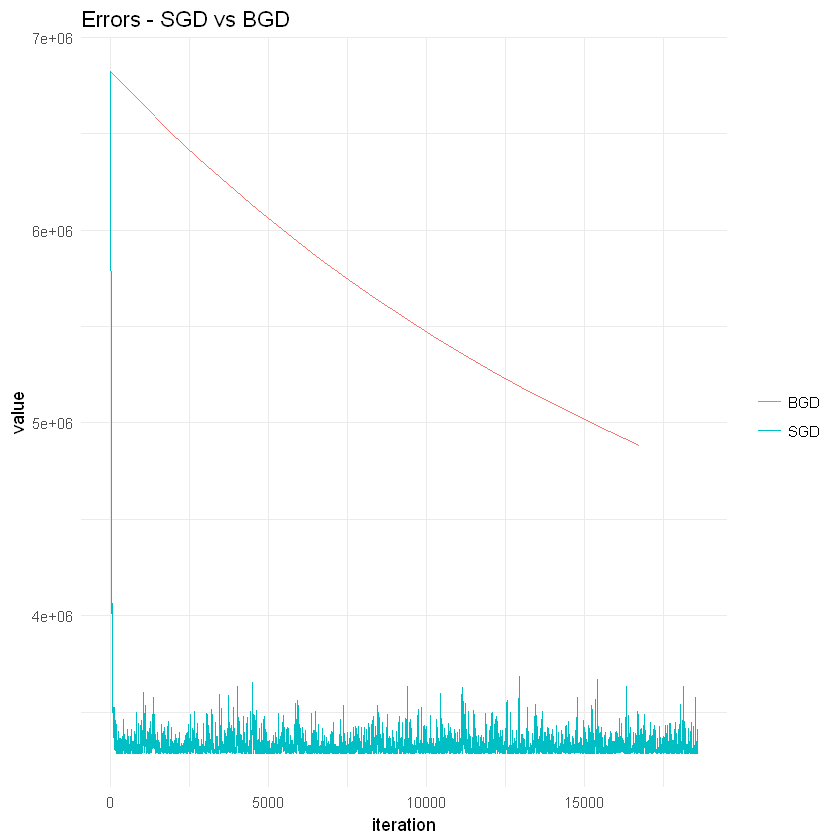

In [5]:
##############################################################################################################################
#
# MAIN LOGIC FOR QUESTION 1
#
##############################################################################################################################

# read the data
trainingA.file <- read.csv('Task2A_train.csv')
testingA.file <- read.csv('Task2A_test.csv')

# scale the input variable values (for faster computation - and to avoid producing errors as high as INF (infinity))
trainingA.data <- scale(trainingA.file[,-ncol(trainingA.file)])
trainingA.value <- trainingA.file[,ncol(trainingA.file)]

# initialise the parameters in building the models
max_epoch = 20
epsilon = .0001 * mean(trainingA.value)
eta = .01
lambda = 1

# create a linear regression model using Stochastic Gradient Descent (SGD)
respSGD <- sgd(trainingA.value, trainingA.data, max_epoch, eta, epsilon, lambda)

# create a linear regression model using Batch Gradient Descent (BGD)
respBGD <- bgd(trainingA.value, trainingA.data, max_epoch, eta, epsilon, lambda)

# format the responses for plotting
# 1. merge both BGD and SGD (training) errors
# 2. melt the table by "iteration" column
# 3. omit null values
errorsA <- merge(respBGD$vals,respSGD$vals,by="iteration", all = TRUE)
errorsA.melt <- melt(errorsA, id = "iteration")
errorsA.melt <- na.omit(errorsA.melt)

ggplot(data=errorsA.melt, aes(x=iteration, y=value, color=variable)) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
       ggtitle("Errors - SGD vs BGD")

__Q1-3D__. Explain your observation based on the errors plot you generated in Part C. Particularly, discuss the convergence speed and the fluctuations you see in the error trends.

**SGD** converges faster than **BGD**. However, the error **gradually decreases** for BGD until it reaches a minimum, while in SGD the error **fluctuates** from high to low (and vice-versa) due to its stochastic nature. BGD approaches the minimum directly and does not regress into a larger error because it takes a single start point and steeps into a gradual descent. SGD may approach the minimum faster but the resulting errors are unstable (in the sense that the next error may be bigger than the previous one) because it starts at a random point every time it attempts to descent.

## Part B. Bias-Variance Analysis
In this part, you conduct a bias-variance study on the Ridge regression that you have developed in Part A. This task assesses your analytical skills, and is based on Chapter 6 of Module 2. You basically recreate Figure 2.6.3 of Module 2 using your implementation of Ridge regression (with SGD) from Part A.

### Question 2 [Bias-Variance for Ridge Regression, 30 Marks]
__2A__. Load __Task2B_train.csv__ and __Task2B_test.csv__ sets,

__2B__. Sample 50 sets from the provided training set, each of which having 100 randomly selected data points (with replacement).

__2C__. For each $\lambda$ in $\{0, 0.2, 0.4, 0.6, \ldots, 5\}$ do:

1. Build 50 regression models using the sampled sets

2. Based on the predictions of these models on the testset, calculate the (average) test error, variance, $(\text{bias})^2$, and  $\text{variance } +(\text{bias})^2$.

Plot the (average) test error, variance, $(\text{bias})^2$, and $\text{variance } +(\text{ bias})^2$ versus $\log (\lambda)$.

In [6]:
##############################################################################################################################
#
# MAIN LOGIC FOR QUESTION 2
# 
# Part 1 - initialisation of values
#
##############################################################################################################################

# read and scale the training and testing files
trainingB.file <- read.csv('Task2B_train.csv')
testingB.file <- read.csv('Task2B_test.csv')
trainingB.data <- scale(trainingB.file[,-ncol(trainingB.file)])
trainingB.value <- scale(trainingB.file[,ncol(trainingB.file)])
testingB.data <- scale(testingB.file[,-ncol(testingB.file)])
testingB.value <- scale(testingB.file[,ncol(testingB.file)])

# add an intercept input variable x0
testingB.data <- as.matrix(cbind('X0'=1, testingB.data))

# initialise values for computation
weights <- c()

# initialise lambdas
lambdas <- c(0, 0.2, 0.4, 0.6, 0.8, 
             1.0, 1.2, 1.4, 1.6, 1.8, 
             2.0, 2.2, 2.4, 2.6, 2.8, 
             3.0, 3.2, 3.4, 3.6, 3.8, 
             4.0, 4.2, 4.4, 4.6, 4.8,
            5.0)

# initialise parameters for the regression models
max_epoch = 20
epsilon = .001 * mean(trainingB.value)
eta = .01

D <- 100  # the number of samples in each selected dataset (100)
L <- 50 # number of datasets (50 bootstraps) 
M <- length(lambdas)  # number of lambdas
N <- nrow(trainingB.data) # number of training data
test.N <- nrow(testingB.data) # number of testing data

# generate a dataframe similar to Activity 2.3 called y
# structure: 
# -------------------------------------------------------------
# | lambda   | bootstrap          | y1 | y2 | y3 | ... | y930 |
#  ---------- -------------------- ---- ---- ---- ----- -------
# |(0 - 5.0) | 1-50 (per lambda)  | predicted value for y_n   |
# -------------------------------------------------------------
# instead of models (polynomial orders), we have lambdas instead

# create empty matrix to record result in each sampling iteration
y <- data.frame(matrix(0,nrow=L*M, ncol=test.N+2))
names(y) <- c('m', 'l',  paste('y',1:(test.N), sep=''))

# populate the lambdas (M) in the y data frame
j <- 0
for(m in 1:M){
    for(l in 1:L){
        y$m[l + (L*j)] <- lambdas[m]
    }
    j <- j + 1
}

# populate (L)
y$l <- rep(1:L, M, each = 1)

In [7]:
##############################################################################################################################
#
# MAIN LOGIC FOR QUESTION 2
# 
# Part 2 - Creating predictions
#
##############################################################################################################################

# per lambda
for (m in c(1:M)){
    for (l in 1:L){
        # create L (50) bootstraps 
        indexes <- sample(1:nrow(trainingB.file), D, replace = TRUE)
        # create a model using the training bootstrap
        weights <- sgd(trainingB.value[indexes], trainingB.data[indexes,], max_epoch, eta, epsilon, lambdas[m])$finalWeights
        # populate the predicted values per y
        y[y$m==lambdas[m] & y$l==l, -c(1,2)] <- predict_func(testingB.data, weights)
    }
}

## Bias
Bias describes how accurate can the model predict the actual values. Mathematically, it is the difference between the expected predicted value and the actual value of the target variable. High bias leads to underfitting, where the model does not sufficiently explain the training data.

$$
\text{Bias} = E[Y_\text{predicted}] - Y_\text{actual}
$$

## Variance
Variance describes the how close (or far) the predicted values are from each other. Mathematically, it is the mean squared differences of the predicted values from its mean. High variance leads to overfitting, where the model extremely fits the training data so well that it fails accommodate other datasets.

$$
\text{Variance} = E[(Y_\text{predicted} - E[Y_\text{predicted}])^2]
$$

## Generalisation Error
The error is the difference of the squared differences between the predicted value and the actual value. In terms of bias and variance, it is $\text{bias}^2 + \text{variance}$.

$$
\text{Generalisation Error} = E[(Y_\text{predicted} - Y_\text{actual})^2]  \\ = (E[Y_\text{predicted}] - Y_\text{actual})^2 + E[(Y_\text{predicted} - E[Y_\text{predicted}])^2]  \\ = \text{bias}^2 + \text{variance} \\                   
$$

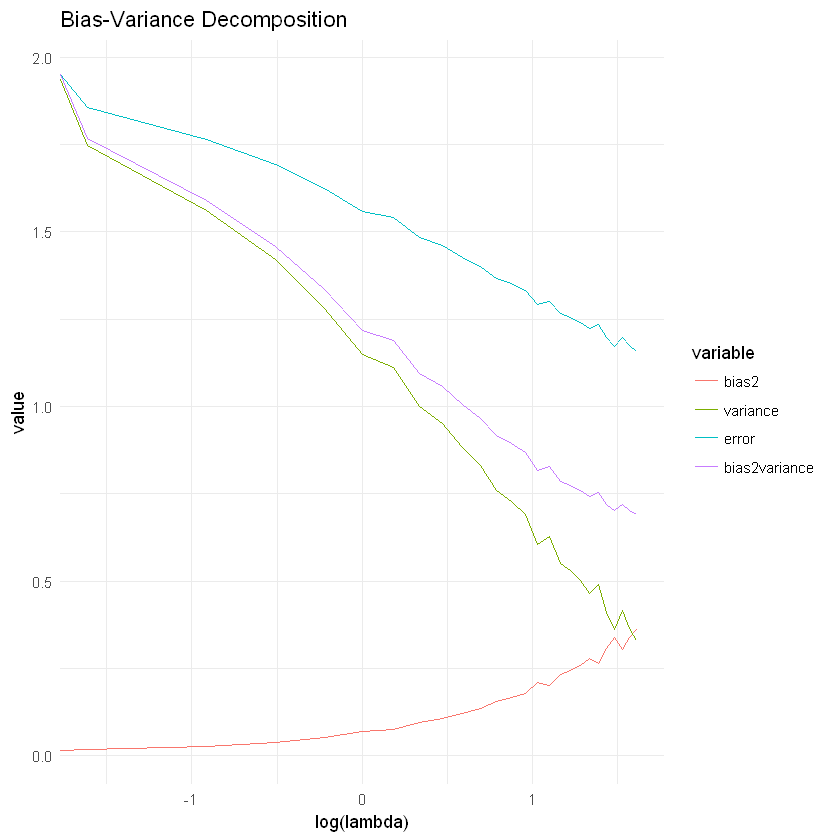

In [8]:
##############################################################################################################################
#
# MAIN LOGIC FOR QUESTION 2
# 
# Part 3 - Computation of bias, variance, and error
#
##############################################################################################################################

# compute mean of the predicted values E[theta_hat]
y.bar <- aggregate(y, list(y$m),mean)
y.bar <- as.matrix(y.bar[,-c(1:3)])

error <- matrix(0,nrow=M)
bias2 <- matrix(0,nrow=M)
variance <- matrix(0,nrow=M)

# for each lambda
for (m in c(1:M)){
    # bias^2 is E[(E[Y_pred] - Y_actual)^2]
    bias2[m] <- mean((y.bar[m,] - testingB.value)^2)
    # variance is E[Y_pred - E[Y_pred]]^2
    variance[m] <- mean((y[y$m==lambdas[m],-c(1,2)]-y.bar[m,])^2)
    # error is E[(Y_pred - Y_actual)^2] 
    error[m] <- mean((y[y$m==lambdas[m],-c(1,2)]-testingB.value)^2)
}

# format data for plotting
dat <- as.data.frame(cbind(lambdas, bias2=bias2, variance, error, bias2+variance))
names(dat) <- c('lambda', 'bias2', 'variance', 'error', 'bias2variance')

dat.m <- melt(dat, id='lambda')
ggplot(data=dat.m, aes(x=log(lambda), y=value, color=variable)) + geom_line() + 
        labs(title='Bias-Variance Decomposition') +  theme_minimal()

__2D__. Based on your plot in the previous step (C), what’s the best value for $\lambda$? Explain your answer in terms of the bias, variance, and test error.

The best value for $\lambda$ is where the **Mean Squared Error** ($\text{bias}^2 + \text{variance}$) is at the minimum. Based on the plot, the ($\text{bias}^2 + \text{variance}$) is at lowest when **$\lambda$ is 5**. According to the lecture slides, the optimal model is where the $\text{bias}^2$ and $variance$ **both** have low values, which is when $\pmb{\lambda = 5}$. Variance decreases dramatically due to the regularisation performed. Bias, although increasing, is increasing at a very slow pace even if we pick higher lambdas.

## Part C. Logistic Regression vs. Bayesian Classifier
This task assesses your analytical skills. You need to study the performance of two well-known generative and discriminative models, i.e. Bayesian classifier and logistic regression, as the size of the training set increases. Then, you show your understanding of the behaviour of learning curves of typical generative and discriminative models.

### Question 3 [Discriminative vs Generative Models, 35 Marks]


__3A__. Load __Task2D_train.csv__ and __Task2D_test.csv__ as well as the Bayesian classifier (BC) and logistic regression (LR) codes from Activities 2 and 3 in Module 3.

### Naive Bayes' Classifier

Naives Bayes Classifier is a generative model. It derives the probability distribution of each class and predicts using these probability distributions, and uses the Bayes' theorem to calculate the posterior probabilities of a data belonging to each class $p(\mathcal{C}_k|x)$. 

To generate the probability distribution using the training data, it requires the following:
- prior probabilities $\pmb{p(\mathcal{C}_k)}$ which is just the fraction of each class in the whole dataset
- class means $\mu_k$
- class covariance matrices $\mathbf{S}_k$
- shared covariance matrix$\Sigma$

The conditional probability $p(x | \mathcal{C}_k)$ is derived from the distribution using the $\mu_k$ and $\Sigma$. In this case, we use the function `dmvnorm()` to derive the probability density function using the means and the covariances.

Once you have calculated $p(\mathcal{C}_k)$ and $p(x|\mathcal{C}_k)$, Bayes theorem can now be used to calculate the posterior $p(\mathcal{C}_k|x)$ probabilities for each testing set. 

$$
p(\mathcal{C}_k|x) = \frac{p\mathcal{C}_k . p(x|\mathcal{C}_k)}{p(x)}
$$

Which ever has the bigger posterior probability is the chosen class for the data.

In [9]:
##############################################################################################################################
#
# AUXILIARY FUNCTION FOR QUESTION 3
# 
# Part 1 - Naive Bayes' Classifier
#
##############################################################################################################################

## Function that creates a Bayesian Classifier 
# train.data - training input variables (x)
# train.label - training target variable (y)
# test.data - testing input variables (x)
# test.label - testing target variable (y)
bayes <- function(train.data, train.label, test.data, test.label) {
    train.label <- factor(train.label)
    test.label <- factor(test.label)
    
    c0 <- levels(train.label)[2]
    c1 <- levels(train.label)[1]

    # Class probabilities:
    # total number of samples in class 0 divided by the total nmber of training data
    p0.hat <- sum(train.label==c0)/nrow(train.data) 
    p1.hat <- sum(train.label==c1)/nrow(train.data) # or simply 1 - p1.hat

    # Class means:
    mu0.hat <- colMeans(train.data[train.label==c0,])
    mu1.hat <- colMeans(train.data[train.label==c1,])

    # class covariance matrices:
    sigma0.hat <- var(train.data[train.label==c0,])
    sigma1.hat <- var(train.data[train.label==c1,])

    # shared covariance matrix: (will produce an n x n matrix) 
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 

    # calculate posteriors:
    posterior0 <- p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma.hat)

    # calculate predictions:
    train.predict <- ifelse(posterior0 > posterior1, c0, c1)
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), c0, c1)
    
    train.error <- 1-sum(train.label==train.predict)/nrow(train.data)
    test.error <- 1-sum(test.label==test.predict)/nrow(test.data)
    
    return(list('trainError'= train.error, 'testError' = test.error))

}

### Logistic Regression

Logistic Regression, on the other hard, is a discriminative algorithm. It does not derive the probability distributions of each class but is just concerned with finding the **decision boundary**, that is, finding a line  (or lines) that discriminates each classes in the feature space. The posterior probability $p(\mathcal{C}_k|x)$ of a data belonging to each class is calculated directly using the *sigmoid function*  $\sigma(\pmb{w}.\mathbf{x})$:

$$
p(\mathcal{C}_k|x) = \sigma(\pmb{w}.\mathbf{x}) = \frac{1}{1 + e ^{-(u)}}
$$

$\text{where u} = \pmb{w_0} + \pmb{w_1}.\mathbf{x_1} + ... + \pmb{w_j}.\mathbf{x_j}$

Note that the sigmoid function returns a result $[0, 1]$, which is why it is also $p(\mathcal{C}_k|x)$.

Therefore, in this method we are also concerned with generating the weights of the feature vector, $\pmb{w}$. Gradient descent algorithm can still be used to compute this. Based on Activity 3.3, the steps are as follows:

<ol>
	<li>Implement sigmoid function $\sigma(\pmb{w}.\mathbf{x})$, and initialize weight vector $\pmb{w}$, learning rate $\eta$ and stopping criterion $\epsilon$.</li>
	<li>Repeat the following until the improvement becomes negligible (i.e., $|\mathcal{L}(\pmb{w}^{(\tau+1)})-\mathcal{L}(\pmb{w}^{(\tau)})| \lt \epsilon$):
<ol>
	<li>Shuffle the training data</li>
	<li>For each datapoint in the training data do:
<ol>
	<li>$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} - \eta (\sigma(\pmb{w}.\mathbf{x}) - t_n) \pmb{x}_n$</li>
</ol>
</li>
</ol>
</li>
</ol>

Therefore in the case the following **auxiliary functions** are needed:

- The sigmoid function $\sigma(\pmb{w}.\mathbf{x})$ which is used for prediction
- The cost function $|\mathcal{L}(\pmb{w}^{(\tau+1)})-\mathcal{L}(\pmb{w}^{(\tau)})|$ to determine when to terminate the SGD

In [10]:
##############################################################################################################################
#
# AUXILIARY FUNCTION FOR QUESTION 3
# 
# Part 2 - Logistic Regression
#
##############################################################################################################################

# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculates the cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

# sigmoid function (=p(C_k|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

## Function that creates a Logistic Regression classifier
# train.data - training input variables (x)
# train.label - training target variable (y)
# test.data - testing input variables (x)
# test.label - testing target variable (y)
# max.iteration - maximum number of iterations
# threshold -  error threshold value
# learning.rate - the learning.rate
logistic <- function(train.data, train.label, test.data, test.label, max.iteration, threshold, learning.rate){
    
    train.label <- factor(train.label)
    test.label <- factor(test.label)
    
    c0 <- levels(train.label)[2]
    c1 <- levels(train.label)[1]

    X <- as.matrix(train.data) # rename just for convenience
    Y <- ifelse(train.label==c0,0,1)
    
    train.len <- nrow(X)
    
    W <- matrix(,nrow=max.iteration, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
    W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

    # project data using the sigmoid function (just for convenient)
    Y_pred <- sigmoid(W[1,],X)
    
    costs <- data.frame('iteration'=1:max.iteration)  # to be used to trace the cost in each iteration
    costs[1, 'cost'] <- cost(W[1,],X,Y,c0)
    
    iteration <- 1
    terminate <- FALSE
    while(!terminate){
        # check termination criteria:
        terminate <- iteration >= max.iteration | cost(W[iteration,],X,Y,c0)<=threshold

        # shuffle data:
        train.index <- sample(1:train.len, train.len, replace = FALSE)
        X <- X[train.index,]
        Y <- Y[train.index]

        # for each datapoint:
        for (i in 1:train.len){
            # check termination criteria:
            if (iteration >= max.iteration | cost(W[iteration,],X,T, c0) <=threshold) {terminate<-TRUE;break}

            Y_pred <- sigmoid(W[iteration,],X)

            # update the weights
            W[(iteration+1),] <- W[iteration,] - learning.rate * (Y_pred[i]-Y[i]) * cbind(1, t(X[i,]))

            # record the cost:
            costs[(iteration+1), 'cost'] <- cost(W[iteration,],X,Y, c0)

            # update the counter:
            iteration <- iteration + 1

            # decrease learning rate:
            learning.rate = learning.rate * 0.999
        }
    }
    # Done!
    costs <- costs[1:iteration, ] # remove the NaN tail of the vector (in case of early stopping)

    # the  final result is:
    w <- W[iteration,]
    
    train.error <- 1 - (sum(predict(w, train.data, c0, c1) == train.label) / nrow(train.data))
    test.error <- 1 - (sum(predict(w, test.data, c0, c1) == test.label) / nrow(test.data))
    
    return(list('trainError'= train.error, 'testError' = test.error))
    
}

__3B__. Using the first 5 data points from the training set, train a BC and a LR model, and compute their test errors. In a “for loop”, increase the size of training set (5 data points at a time), retrain the models and calculate their test errors until all training data points are used. In one figure, plot the test errors for each model (with different colors) versus the size of the training set; name the plot “Learning Curve” and add it to your report.


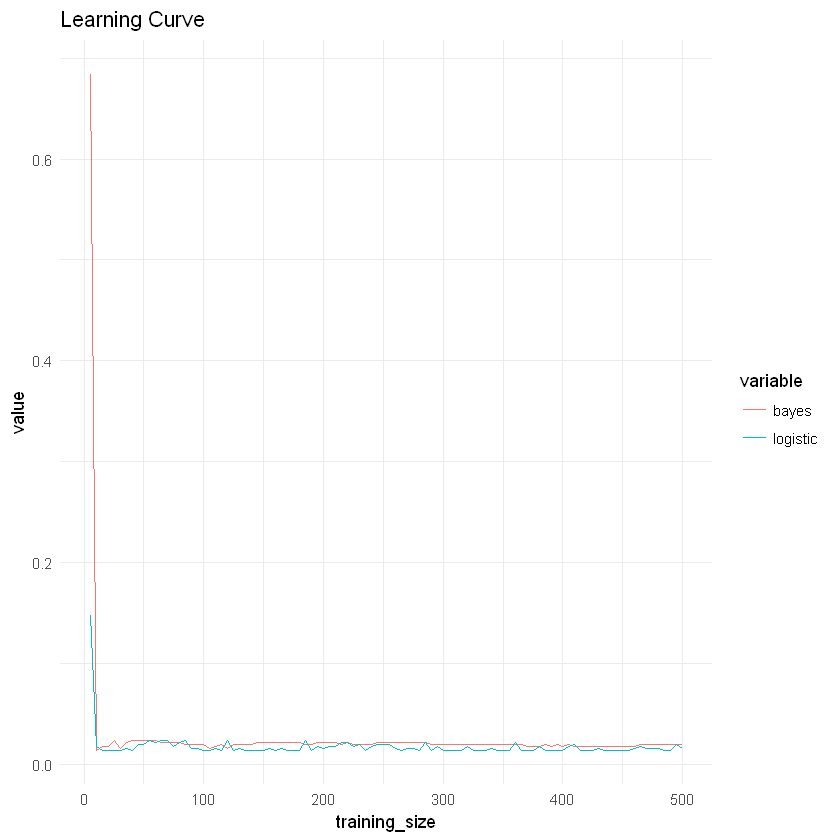

In [11]:
##############################################################################################################################
#
# MAIN LOGIC FOR QUESTION 3
#
##############################################################################################################################

## read the data
trainingD.file <- read.csv('Task2D_train.csv')
testingD.file <- read.csv('Task2D_test.csv')
trainD.data <- trainingD.file[,-ncol(trainingD.file)]
trainD.label <- trainingD.file[,ncol(trainingD.file)]
testD.data <- testingD.file[,-ncol(testingD.file)]
testD.label <- testingD.file[,ncol(testingD.file)]

## initialise values
D <- 5 # increase training data by adding 5 per iteration
tau.max <- 1000 # max. number of iterations
epsilon <- 0.01 # threshold to determine when to stop
eta <- 0.01 # learning rate
max.iteration <- nrow(trainingD.file) / D # number of data divided by D 
errorsC <-  data.frame('training_size' = 1:max.iteration)

## main logic
for (i in 1:max.iteration){
    # retrieve required number of training data
    t.data <- trainD.data[1:(D*i),]
    t.label <- trainD.label[1:(D*i)]
    
    # use it to train and predict test values 
    # errors will be returned by the models
    errorsC[i, 'training_size'] <- (D*i)
    errorsC[i, 'bayes'] <- bayes(t.data, t.label, testD.data, testD.label)$testError
    errorsC[i, 'logistic'] <- logistic(t.data, t.label, testD.data, testD.label, tau.max, epsilon, eta)$testError
    
}

## plot the errors
errorsC.melt <- melt(errorsC, id = "training_size")
errorsC.melt <- na.omit(errorsC.melt)

ggplot(data=errorsC.melt, aes(x=training_size, y=value, color=variable)) + geom_line() + 
        labs(title='Learning Curve') +  theme_minimal()

__3C__. Explain your observations in your report:
    1. What does happen for each classifier when the number of training datapoints is increased?

Both **Bayes Classifier (BC)** and **Logistic Regression (LR)** models perform better as the training size increases. In the case of the Task_2D datasets, both  gave out accurate predictions even with small training sizes. However, in general BC trains faster (can learn quickly in small training sets) but LR has better performance (i.e. lower error rates; better accuracy rate) than BC.

    2. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?

**Bayes Classifier** is better for small training sets, while **Logistic Regression** is better for big training sets.

    3. Justify your observations in  C.1 and C.2 by providing some speculations and possible reasons.

**Bayes Classifier** is best suited when the training set is small, because the model tends to **have low variance**. It is less prone to overfitting with small samples but tends to **have high bias** because it always assumes the features it uses to predict are independent.

**Logistic Regression** is best suited when the training set is big, because the model tends to **have high variance**. LR is more prone to overfitting with small datasets but has **low bias** and is more robust than BC because it also considers correlations between the features and doesn't do any naive assumptions.
